## Advanced Time Series Modeling

When do we use an AR model?
- When we are measuring/predicting a long term trend

When do we use MA model?
- When we anticipate time series to have substantial, sudden shocks in the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [4]:
stocks = pd.read_csv('./datasets/stocks_data.csv')
stocks.index = pd.date_range(start = '1/1/1998',
                                periods = len(stocks['date']),
                                freq = 'M')
# Drop date column.
stocks.drop(columns = 'date', inplace = True)

# Print shape of dataframe.
print(stocks.shape)

# Check head of dataframe.
stocks.head()

(188, 6)


,AAPL,DOW,INTC,NKE,SBUX,YHOO
1998-01-31,429827197.2,1.209317e+08,1.661023e+09,7.959626e+07,293173270.9,850634400
1998-02-28,472442891.2,1.076107e+08,1.557596e+09,1.728604e+08,195688833.4,812745601
1998-03-31,289967681.9,3.199504e+08,1.302454e+09,1.313051e+08,200276117.7,508606400
1998-04-30,204349358.0,8.812538e+07,1.528902e+09,1.122555e+08,169892162.9,435661445
1998-05-31,262567704.3,8.690630e+07,1.324581e+09,9.772757e+07,129467760.4,421181942


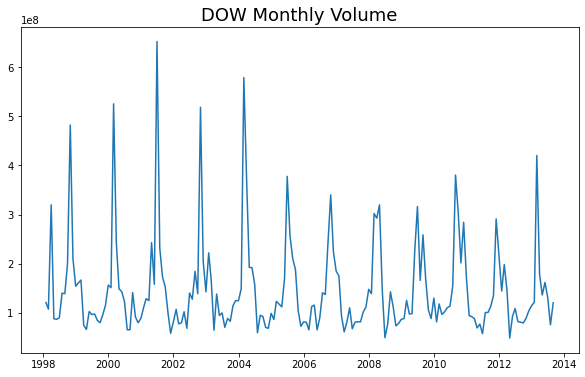

In [5]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(stocks['DOW'])
plt.title(label = 'DOW Monthly Volume', fontsize=18)
plt.show();

In [6]:
# Run this for now - we'll use this later!
stocks['INTC_lag_1'] = stocks['INTC'].shift(1)
stocks.head()

,AAPL,DOW,INTC,NKE,SBUX,YHOO,INTC_lag_1
1998-01-31,429827197.2,1.209317e+08,1.661023e+09,7.959626e+07,293173270.9,850634400,NaN
1998-02-28,472442891.2,1.076107e+08,1.557596e+09,1.728604e+08,195688833.4,812745601,1.661023e+09
1998-03-31,289967681.9,3.199504e+08,1.302454e+09,1.313051e+08,200276117.7,508606400,1.557596e+09
1998-04-30,204349358.0,8.812538e+07,1.528902e+09,1.122555e+08,169892162.9,435661445,1.302454e+09
1998-05-31,262567704.3,8.690630e+07,1.324581e+09,9.772757e+07,129467760.4,421181942,1.528902e+09
